In [1]:
"""
Alexandre
2024/10/18
"""

'\nAlexandre\n2024/10/18\n'

# **Initial tests**

## Initialisation part

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import nest
import os


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug  5 2024 06:09:47

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
cwd = os.getcwd()
print(cwd)

results_fodler_name = "B_results"
os.makedirs(
    os.path.join(cwd, results_fodler_name),
    exist_ok=True
)

/root/EBRAIN-Fall-School/nest_project_eitn_24/Encoding_Layer_Alexandre


## network generation

In [4]:
# general parameters
gamma = 0.25 # relative number of inhibitory

# encoding layer parameters
nEnc = 500  # number of neurons in the encoding layer
J_bias = 200. # [pA]

# main network parameters
NE = 1000 # number of excitatory neurons (10.000 in [1])
CE = 200 # indegree from excitatory neurons

# synapse parameters
w = 0.1 # excitatory synaptic weight (mV)
g = 5. # relative inhibitory to excitatory synaptic weight
d = 1.5 # synaptic transmission delay (ms)

In [5]:
def gen_network(
    gamma=gamma,
    # encoding layer parameters
    nEnc=nEnc,
    J_bias=J_bias,
    # main network parameters
    NE=NE,
    CE=CE, # indegree from excitatory neurons

    # synapse parameters
    w=w, # excitatory synaptic weight (mV)
    g=g, # relative inhibitory to excitatory synaptic weight
    d=d, # synaptic transmission delay (ms)
):
 
    # create the encoding layer
    enc_layer = nest.Create(
        model='iaf_psc_delta', 
        n=nEnc, 
        params={'I_e': J_bias}
    )

    # record the activity of the encoding layer
    enc_spks = nest.Create('spike_recorder')
    nest.Connect(enc_layer, enc_spks)


    ##### MAIN NETWORK #####
    # population parameters
    NI = int(gamma * NE) # number of inhibitory neurons
    CI = int(gamma * CE) # indegree from inhibitory neurons

    # neuron paramters
    neuron_params = {
        'C_m': 1.0,            # membrane capacity (pF)
        'E_L': 0.,             # resting membrane potential (mV)
        'I_e': 0.,             # external input current (pA)
        'V_m': 0.,             # membrane potential (mV)
        'V_reset': 10.,        # reset membrane potential after a spike (mV)
        'V_th': 20.,           # spike threshold (mV)
        't_ref': 2.0,          # refractory period (ms)
        'tau_m': 20.,          # membrane time constant (ms)
    }

    # set default parameters for neurons and create neurons
    nest.SetDefaults('iaf_psc_delta', neuron_params)
    neurons_e = nest.Create('iaf_psc_delta', NE)
    neurons_i = nest.Create('iaf_psc_delta', NI)

    # create spike detectors
    main_spks = nest.Create('spike_recorder')

    # E synapses
    syn_exc = {'delay': d, 'weight': w}
    conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
    nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
    nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

    # I synapses
    syn_inh = {'delay': d, 'weight': - g * w}
    conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
    nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
    nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

    # spike detector
    nest.Connect(neurons_e, main_spks)

    # connect the encoding layer to both neuronal population
    nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
    nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)

    return enc_layer, enc_spks, main_spks

In [6]:
# set general parameters
seed = 1
dt = 0.1
num_threads = 16

# initialize nest kernel
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': num_threads
})

# generate the network
enc_layer, enc_spks, main_spks = gen_network()


Oct 21 08:20:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


## generate input and connect it to the network

In [7]:
# import librairies input stimulus generator
from utils.inputs import generate_piecewise_constant_signal

In [8]:
# encoding layer parameters
nEnc = 500 # number of neurons in the encoding layer

# stimulus parameters
step_duration = 20. # [ms]
scale = 1000. # input scaling factor [Hz]
num_steps = 100 # number of unique input values

In [9]:
def gen_input(
    # encoding layer parameters
    nEnc=nEnc,  # number of neurons in the encoding layer

    # stimulus parameters
    step_duration=step_duration, # [ms]
    scale=scale, # input scaling factor [Hz]
    num_steps=num_steps, # number of unique input values
):
    
    # encoding layer reparametrisation
    tuning = 250. * np.random.randn(nEnc) + 1000. # 
    thresholds = 5 * np.random.randn(nEnc) - 45. # generate some heterogeneity on the population
    Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc))) # randomized initiate point of each neuron

    # generation of the stimulus
    sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(
        seed=seed, 
        num_steps=num_steps,
        step_duration=step_duration, 
        resolution=dt, 
        scale=scale
        )

    # create inhomogeneous poisson generator (time-dependent input signal)
    stim_pgen = nest.Create(
        model='inhomogeneous_poisson_generator', 
        n=1
    )

    stim_pgen.set(
        {
            'rate_times': inp_times, 
            'rate_values': inp_amplitudes
        }
    )

    step_generator = nest.Create(
        model='step_current_generator', 
        n=nEnc
    )
    amplitudes = np.zeros((nEnc, len(inp_amplitudes)))

    for n in range(nEnc): # for each neuron in the encoding layer
        
        # transform the input as function of the tuning of each neuron
        amplitudes[n, :] = inp_amplitudes * tuning[n]/1000
        
        # change parameters of each neuron in the input layer
        enc_layer[n].set(
            {
                'V_m': Vm0[n], # set the membrane potential initialisation
                'V_th': thresholds[n] # set the excitation threshold
            }
        )

        # change caracteristics of the input generator
        step_generator[n].set(
            {
                'amplitude_times': inp_times, # set the time
                'amplitude_values': amplitudes[n] # set the amplitude
            }
        )

        # connect the input generator to the encoding layer neuron one-by-one
        nest.Connect(
            step_generator[n],
            enc_layer[n]
        )
    
    return sig, times, inp_times, inp_amplitudes

In [10]:
sig, times, inp_times, inp_amplitudes = gen_input()

## extract simulation results

In [11]:
# run the simulation
sim_time = num_steps*step_duration
nest.Simulate(sim_time)

# extract the simulation results
from utils.extractors import filter_spikes_parallel

filter_tau = 20. # [ms]


Oct 21 08:20:36 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 08:20:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 08:20:41 SimulationManager::run [Info]: 
    Simulation finished.


In [12]:
def extract_results(
        enc_spks=enc_spks,
        main_spks=main_spks,
        filter_tau=filter_tau,
        sim_time=sim_time,
        nEnc=nEnc, NE=NE,
        dt=dt,
        num_threads=num_threads

):
    
    enc_activity = enc_spks.events
    enc_states = filter_spikes_parallel(
        enc_activity['times'], enc_activity['senders'], # use the timing and the origin of each spike of the encoding layer
        nEnc, # total number of neuron in the encoding layer
        t_start=0., t_stop=sim_time, dt=dt, # begin, end and time-step of the simulation
        tau=filter_tau, 
        n_processes=num_threads
    )

    main_activity = main_spks.events
    main_states = filter_spikes_parallel(
        main_activity['times'], main_activity['senders'], 
        NE, 
        t_start=0., t_stop=sim_time, dt=dt, 
        tau=filter_tau, 
        n_processes=num_threads
    )

    return enc_activity, enc_states, main_activity, main_states

In [13]:
enc_activity, enc_states, main_activity, main_states = extract_results()

Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:27<00:00, 36.26it/s]


## decoding the activity

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
def compute_capacity(x, z):
    """
    Compute capacity to reconstruct z based on linearly combining x

    Parameters
    ----------
    x : np.ndarray
        state matrix(NxT)
    z : np.ndarray
        target output (1xT)

    Returns
    -------
    z_hat : np.ndarray
        Reconstructed (predicted) signal

    """
    reg = LinearRegression(
        n_jobs=-1, 
        fit_intercept=False
    ).fit(x.T, z)
    
    W_out = reg.coef_
    z_hat = np.dot(W_out, x)

    covs = np.cov(z_hat, z)[0, 1] ** 2.0
    vars = np.var(z) * np.var(z_hat)
    capacity = covs / vars

    error = np.mean((z - z_hat) ** 2)
    return z_hat, capacity, error

In [16]:
enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[:-1])
main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[:-1])

print(f"Encoding Layer: \n\t- Capacity={enc_capacity}, MSE={enc_error}")
print(f"Main Circuit: \n\t- Capacity={main_capacity}, MSE={main_error}")

Encoding Layer: 
	- Capacity=0.5466007243918394, MSE=0.15024578435591524
Main Circuit: 
	- Capacity=0.55397335508295, MSE=0.16605617197235373


## run simulation

In [17]:
# initialize nest kernel
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': num_threads
})

# generate the network
enc_layer, enc_spks, main_spks = gen_network(
    gamma=gamma,
    nEnc=nEnc,
    J_bias=J_bias,
    NE=NE, CE=CE,
    w=w, g=g, d=d
)

# generation input and connect it to the network
sig, times, inp_times, inp_amplitudes = gen_input(
    nEnc=nEnc,
    step_duration=step_duration,
    num_steps=num_steps
)

# run the simulation
sim_time = num_steps*step_duration
nest.Simulate(sim_time)

# results extraction
enc_activity, enc_states, main_activity, main_states = extract_results(
    enc_spks=enc_spks,
    main_spks=main_spks,
    filter_tau=filter_tau,
    nEnc=nEnc, NE=NE
)

enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[:-1])
main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[:-1])

print(f"Encoding Layer: \n\t- Capacity={enc_capacity}, MSE={enc_error}")
print(f"Main Circuit: \n\t- Capacity={main_capacity}, MSE={main_error}")


Oct 21 08:21:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 08:21:42 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 08:21:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 08:21:48 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:28<00:00, 34.68it/s]


Encoding Layer: 
	- Capacity=0.5488173222464379, MSE=0.1495070778243039
Main Circuit: 
	- Capacity=0.5545627257936206, MSE=0.16753290332978107


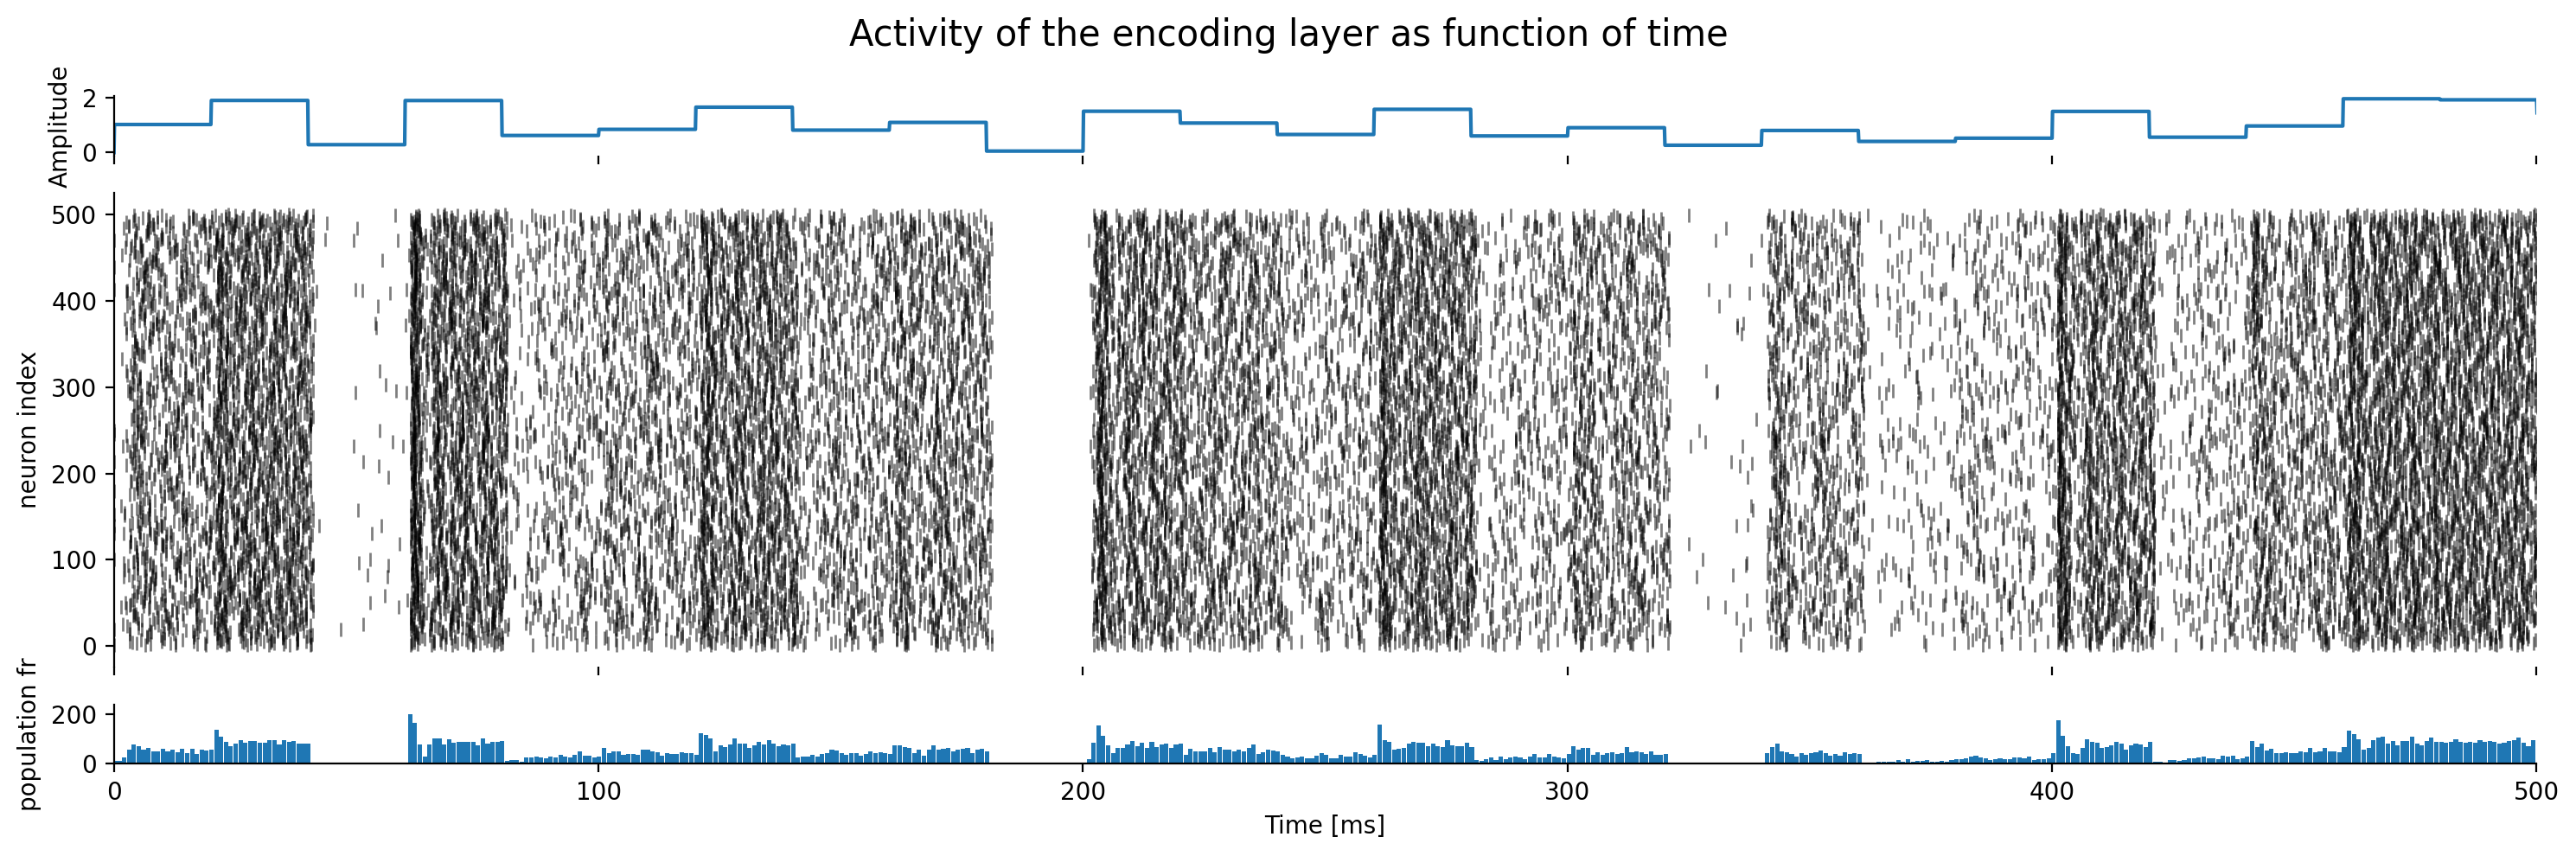

In [18]:
# graphical representation of the encoding layer spiking activity
fig,ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(15,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.1,0.8,0.1]},
    sharex=True
)

ax[0].plot(
    times,
    sig
)

ax[1].plot(
    enc_spks.events["times"],
    enc_spks.events["senders"],
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    enc_spks.events["times"],
    bins=np.linspace(
        enc_spks.events["times"].min(), 
        enc_spks.events["times"].max(), 
        int(enc_spks.events["times"].max())
    )
)

ax[2].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_xlim(0, 500)
ax[0].set_ylabel(r'Amplitude')
ax[0].spines[["top","right","bottom"]].set_visible(False)

ax[1].set_ylabel(r"neuron index")
ax[1].spines[["top","bottom","right"]].set_visible(False)

ax[2].set_ylabel(r"population fr")
ax[2].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'Time [ms]')

fig.suptitle("Activity of the encoding layer as function of time", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_encoding_layer.pdf"), dpi=200)
plt.show()

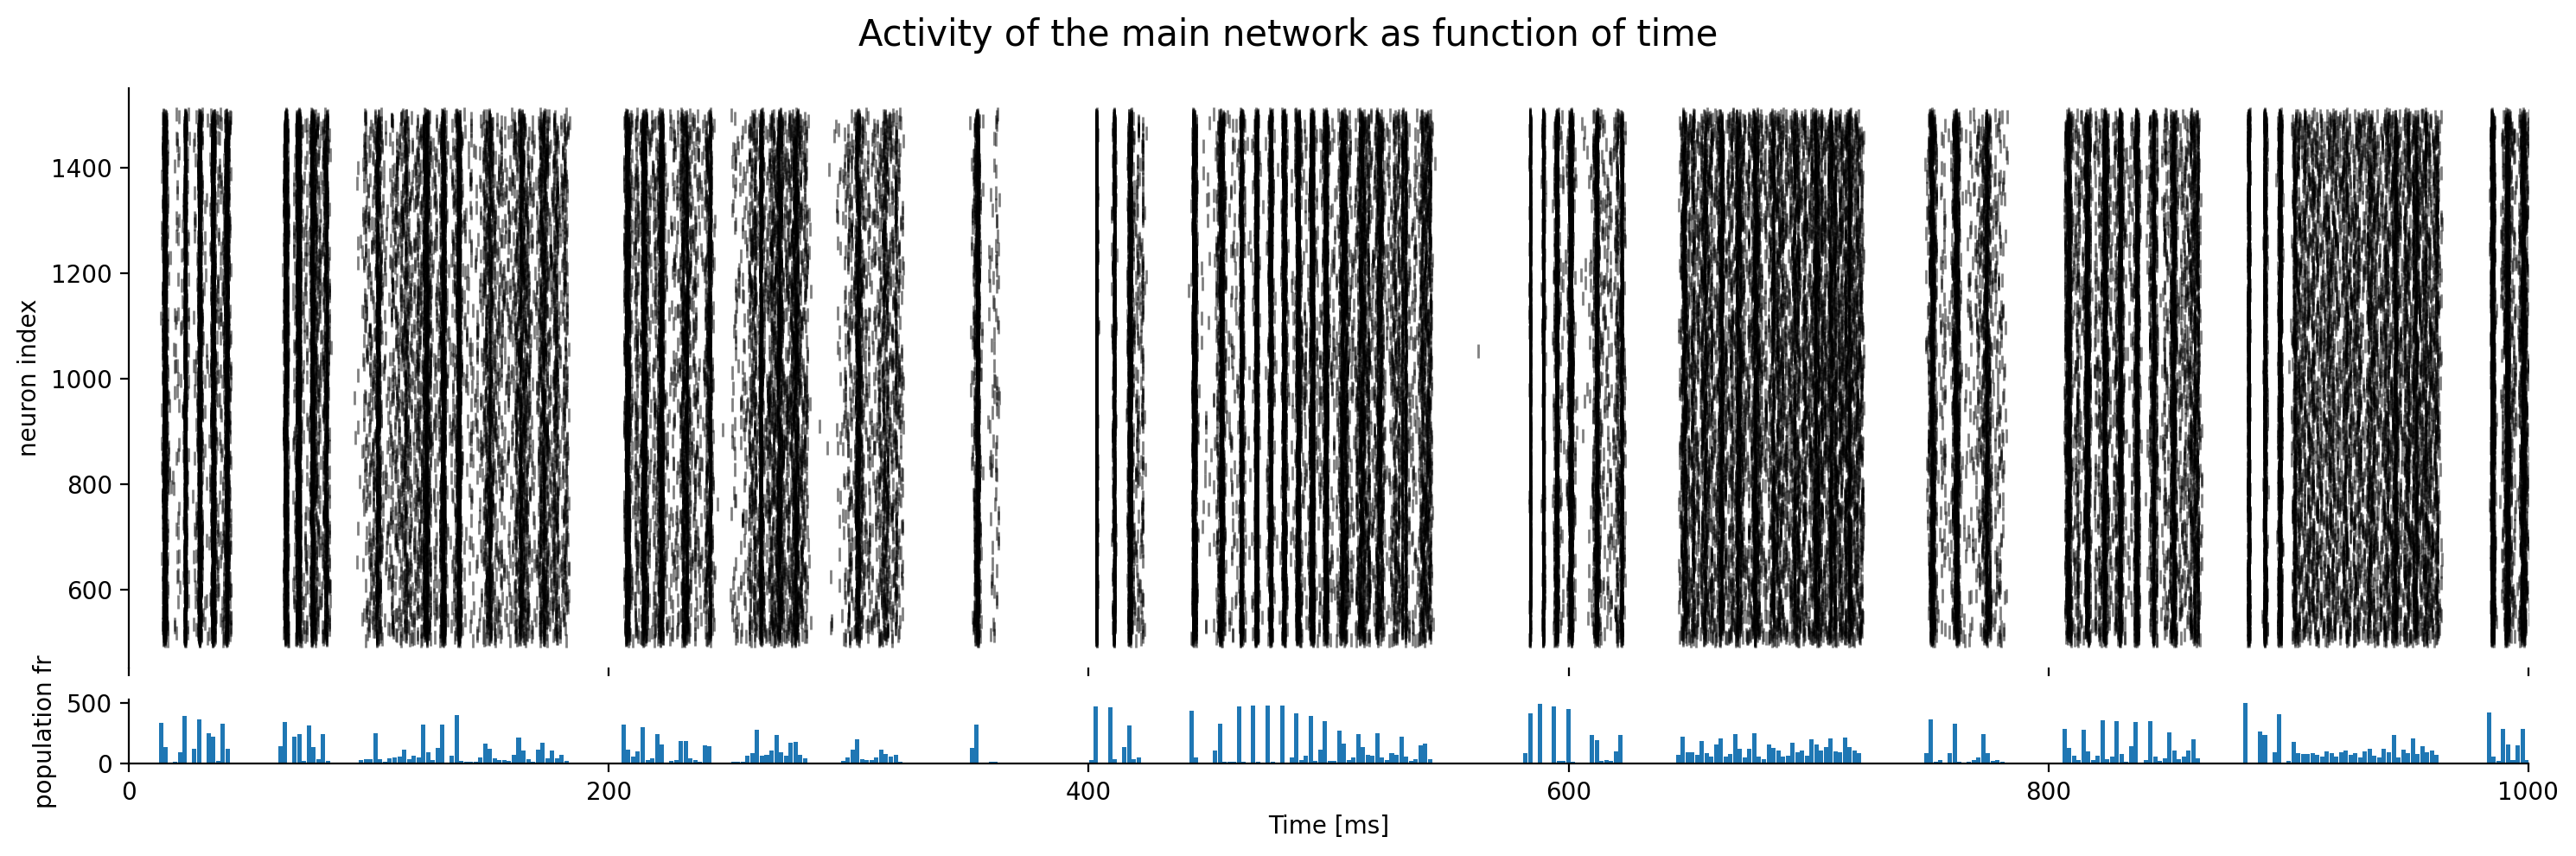

In [19]:
# graphical representation of the main network
fig,ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.9,0.1]},
    sharex=True
)

ax[0].plot(
    main_spks.events["times"],
    main_spks.events["senders"],
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    main_spks.events["times"],
    bins=np.linspace(main_spks.events["times"].min(), main_spks.events["times"].max(), 1_000)
)

ax[1].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_xlim(0, 1_000)
ax[0].set_ylabel(r"neuron index")
ax[0].spines[["top","bottom","right"]].set_visible(False)

ax[1].set_ylabel(r"population fr")
ax[1].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'Time [ms]')

fig.suptitle("Activity of the main network as function of time", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_main_network.pdf"), dpi=200)
plt.show()

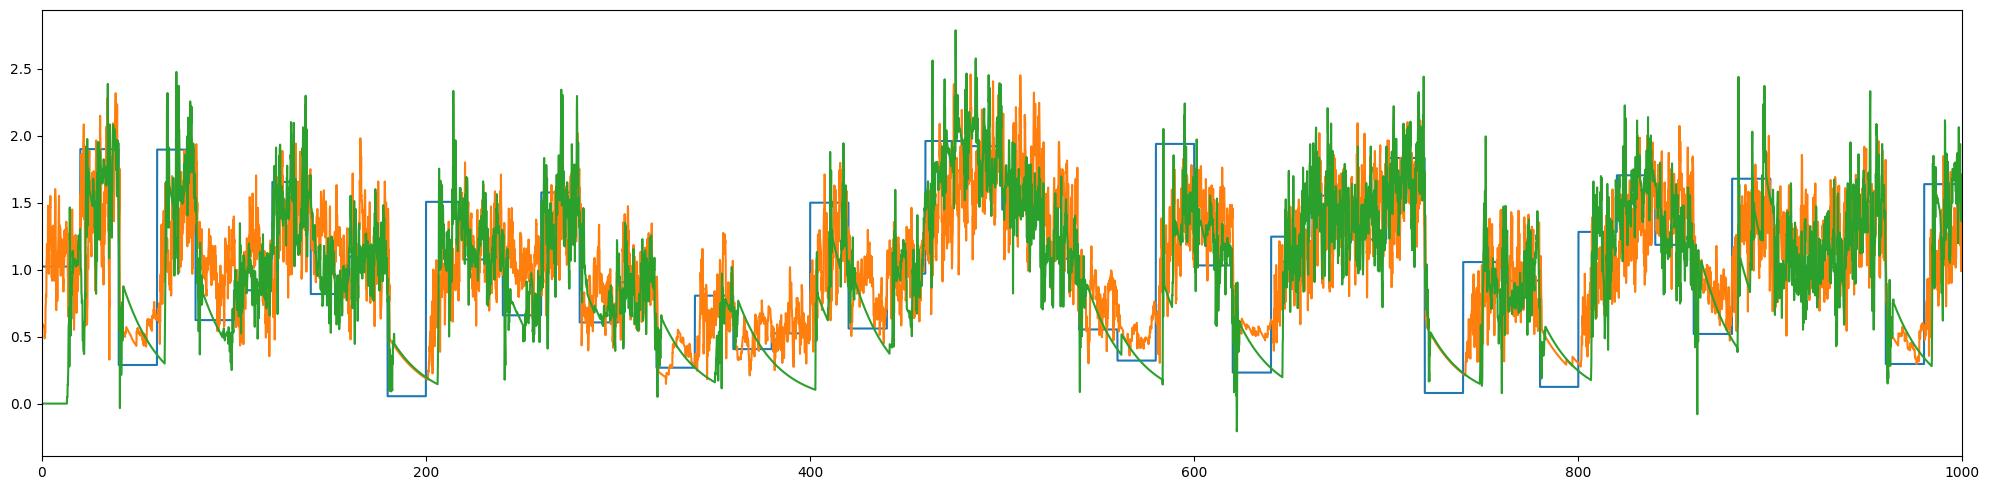

In [20]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(20,5)
)

ax.plot(
    times,
    sig
)

ax.plot(
    times[:-1],
    enc_estimate   
)

ax.plot(
    times[:-1],
    main_estimate
)

ax.set_xlim(0,1_000)

plt.tight_layout()
plt.show()

## influence of each parameters

### change the step duration

In [52]:
step_duration_range = np.linspace(1, 101, 41)
print(step_duration_range)

[  1.    3.5   6.    8.5  11.   13.5  16.   18.5  21.   23.5  26.   28.5
  31.   33.5  36.   38.5  41.   43.5  46.   48.5  51.   53.5  56.   58.5
  61.   63.5  66.   68.5  71.   73.5  76.   78.5  81.   83.5  86.   88.5
  91.   93.5  96.   98.5 101. ]


In [ ]:
for step_dur in step_duration_range:

    if os.path.exists(os.path.join(results_fodler_name, "step_duration", f"main_capacity_stepdur_{step_dur}.npy")):
        print("Already compute !")
        
    else:
        # initialize nest kernel
        nest.ResetKernel()
        nest.SetKernelStatus({
            'rng_seed': seed,
            'resolution': dt,
            'local_num_threads': num_threads
        })

        # generate the network
        enc_layer, enc_spks, main_spks = gen_network(
            gamma=gamma,
            nEnc=nEnc,
            J_bias=J_bias,
            NE=NE, CE=CE,
            w=w, g=g, d=d
        )

        # generation input and connect it to the network
        sig, times, inp_times, inp_amplitudes = gen_input(
            nEnc=nEnc,
            scale=scale,
            step_duration=step_dur,
            num_steps=num_steps,
        )

        # run the simulation
        sim_time = num_steps * step_dur
        nest.Simulate(sim_time)

        # results extraction
        enc_activity, enc_states, main_activity, main_states = extract_results(
            enc_spks=enc_spks,
            main_spks=main_spks,
            filter_tau=filter_tau,
            nEnc=nEnc, NE=NE,
            sim_time=sim_time
        )

        print(sig[:-1].shape, enc_states.shape)
        enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[:-1])
        main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[:-1])

        np.save(os.path.join(results_fodler_name, "step_duration", f"main_capacity_stepdur_{step_dur}"), main_error)
        np.save(os.path.join(results_fodler_name, "step_duration", f"main_estimate_stepdur_{step_dur}"), main_estimate)

Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !
Already compute !

Oct 21 09:02:33 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:02:34 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:02:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 5350
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:02:47 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:10<00:00, 14.21it/s]


(53500,) (500, 53500)

Oct 21 09:04:38 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:04:39 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:04:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 5600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:04:52 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:13<00:00, 13.65it/s]


(56000,) (500, 56000)

Oct 21 09:06:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:06:50 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:06:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 5850
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:07:03 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:16<00:00, 13.05it/s]


(58500,) (500, 58500)

Oct 21 09:09:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:09:05 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:09:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 6100
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:09:20 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:19<00:00, 12.55it/s]


(61000,) (500, 61000)

Oct 21 09:11:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:11:27 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:11:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 6350
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:11:42 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:24<00:00, 11.85it/s]


(63500,) (500, 63500)

Oct 21 09:13:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:13:55 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:13:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 6600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:14:11 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:26<00:00, 11.56it/s]


(66000,) (500, 66000)

Oct 21 09:16:28 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:16:29 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:16:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 6850
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:16:46 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:29<00:00, 11.18it/s]


(68500,) (500, 68500)

Oct 21 09:19:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:19:08 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:19:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 7100
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:19:25 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:32<00:00, 10.83it/s]


(71000,) (500, 71000)

Oct 21 09:21:51 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:21:52 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:21:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 7350
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:22:09 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:41<00:00,  9.88it/s]


(73500,) (500, 73500)

Oct 21 09:24:45 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:24:46 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:24:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 7600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:25:05 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:44<00:00,  9.54it/s]


(76000,) (500, 76000)

Oct 21 09:27:51 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:27:51 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:27:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 7850
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:28:11 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:48<00:00,  9.22it/s]


(78500,) (500, 78500)

Oct 21 09:31:02 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:31:03 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:31:03 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 8100
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:31:23 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:52<00:00,  8.92it/s]


(81000,) (500, 81000)

Oct 21 09:34:20 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:34:21 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:34:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 8350
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:34:42 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [02:00<00:00,  8.27it/s]


(83500,) (500, 83500)

Oct 21 09:37:50 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:37:50 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:37:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 8600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:38:15 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:58<00:00,  8.43it/s]


(86000,) (500, 86000)

Oct 21 09:41:23 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:41:24 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:41:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 8850
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:41:46 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [02:01<00:00,  8.20it/s]


(88500,) (500, 88500)

Oct 21 09:44:59 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:44:59 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:45:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 9100
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:45:22 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [02:05<00:00,  7.98it/s]


(91000,) (500, 91000)

Oct 21 09:48:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 09:48:41 NodeManager::prepare_nodes [Info]: 
    Preparing 9798 nodes for simulation.

Oct 21 09:48:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9798
    Simulation time (ms): 9350
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 09:49:05 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains:  83%|████████▎ | 829/1000 [01:48<00:27,  6.11it/s]

In [48]:
main_capacity = [np.load(os.path.join(results_fodler_name, "step_duration", f"main_capacity_stepdur_{step_dur}.npy")).item() for step_dur in step_duration_range]

fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10,5),
    dpi=200
)

ax[1].plot(
    [5., 10., 20.], #step_duration_range,
    main_capacity
)
ax[1].set_ylabel("capacity")
ax[1].set_xlabel("step duration [ms]")

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "step_duration_influence.pdf"), dpi=200)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'B_results/step_duration/main_capacity_stepdur_1.0.npy'

### change the number of neuron in the encoding layer

In [43]:
nEnc_range = np.linspace(10, 1_000, 10, dtype=int)
print(nEnc_range)

[  10  120  230  340  450  560  670  780  890 1000]


In [44]:
step_duration = 20.
num_steps = 100

In [45]:
MSE_nEnc = []
C_nEnc = []

for numEnc in nEnc_range:

    sim_time = num_steps * step_duration

    # initialize nest kernel
    nest.ResetKernel()
    nest.SetKernelStatus({
        'rng_seed': seed,
        'resolution': dt,
        'local_num_threads': num_threads
    })

    # generate the network
    enc_layer, enc_spks, main_spks = gen_network(
        gamma=gamma,
        nEnc=numEnc,
        J_bias=J_bias,
        NE=NE, CE=CE,
        w=w, g=g, d=d
    )

    # generation input and connect it to the network
    sig, times, inp_times, inp_amplitudes = gen_input(
        nEnc=numEnc,
        scale=scale,
        step_duration=step_duration,
        num_steps=num_steps,
    )

    # run the simulation
    nest.Simulate(sim_time)

    # results extraction
    enc_activity, enc_states, main_activity, main_states = extract_results(
        enc_spks=enc_spks,
        main_spks=main_spks,
        filter_tau=filter_tau,
        nEnc=numEnc, NE=NE,
        sim_time=sim_time
    )

    print(sig[:-1].shape, enc_states.shape)
    enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[:-1])
    main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[:-1])

    MSE_nEnc.append(main_error)
    C_nEnc.append(main_capacity)


Oct 18 17:55:01 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 18 17:55:01 NodeManager::prepare_nodes [Info]: 
    Preparing 1468 nodes for simulation.

Oct 18 17:55:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1468
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 18 17:55:01 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:15<00:00, 65.16it/s]


(20000,) (10, 20000)

Oct 18 17:55:19 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 18 17:55:19 NodeManager::prepare_nodes [Info]: 
    Preparing 3338 nodes for simulation.

Oct 18 17:55:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3338
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 18 17:55:20 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:15<00:00, 63.90it/s]


(20000,) (120, 20000)

Oct 18 17:55:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 18 17:55:41 NodeManager::prepare_nodes [Info]: 
    Preparing 5208 nodes for simulation.

Oct 18 17:55:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5208
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 18 17:55:42 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:15<00:00, 64.20it/s]


(20000,) (230, 20000)

Oct 18 17:56:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 18 17:56:04 NodeManager::prepare_nodes [Info]: 
    Preparing 7078 nodes for simulation.

Oct 18 17:56:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 7078
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 18 17:56:06 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:15<00:00, 63.06it/s]


(20000,) (340, 20000)

Oct 18 17:56:30 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 18 17:56:30 NodeManager::prepare_nodes [Info]: 
    Preparing 8948 nodes for simulation.

Oct 18 17:56:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 8948
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 18 17:56:33 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:14<00:00, 67.75it/s]


(20000,) (450, 20000)

Oct 18 17:56:57 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 18 17:56:57 NodeManager::prepare_nodes [Info]: 
    Preparing 10818 nodes for simulation.

Oct 18 17:56:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10818
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 18 17:57:00 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:14<00:00, 67.47it/s]


(20000,) (560, 20000)

Oct 18 17:57:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 18 17:57:26 NodeManager::prepare_nodes [Info]: 
    Preparing 12688 nodes for simulation.

Oct 18 17:57:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12688
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 18 17:57:30 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:15<00:00, 65.37it/s]


(20000,) (670, 20000)

Oct 18 17:57:58 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 18 17:57:59 NodeManager::prepare_nodes [Info]: 
    Preparing 14558 nodes for simulation.

Oct 18 17:57:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14558
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 18 17:58:03 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:15<00:00, 65.40it/s]


(20000,) (780, 20000)

Oct 18 17:58:34 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 18 17:58:34 NodeManager::prepare_nodes [Info]: 
    Preparing 16428 nodes for simulation.

Oct 18 17:58:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 16428
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 18 17:58:39 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:16<00:00, 61.62it/s]


(20000,) (890, 20000)

Oct 18 17:59:13 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 18 17:59:14 NodeManager::prepare_nodes [Info]: 
    Preparing 18298 nodes for simulation.

Oct 18 17:59:14 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 18298
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 18 17:59:20 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:15<00:00, 65.92it/s]


(20000,) (1000, 20000)


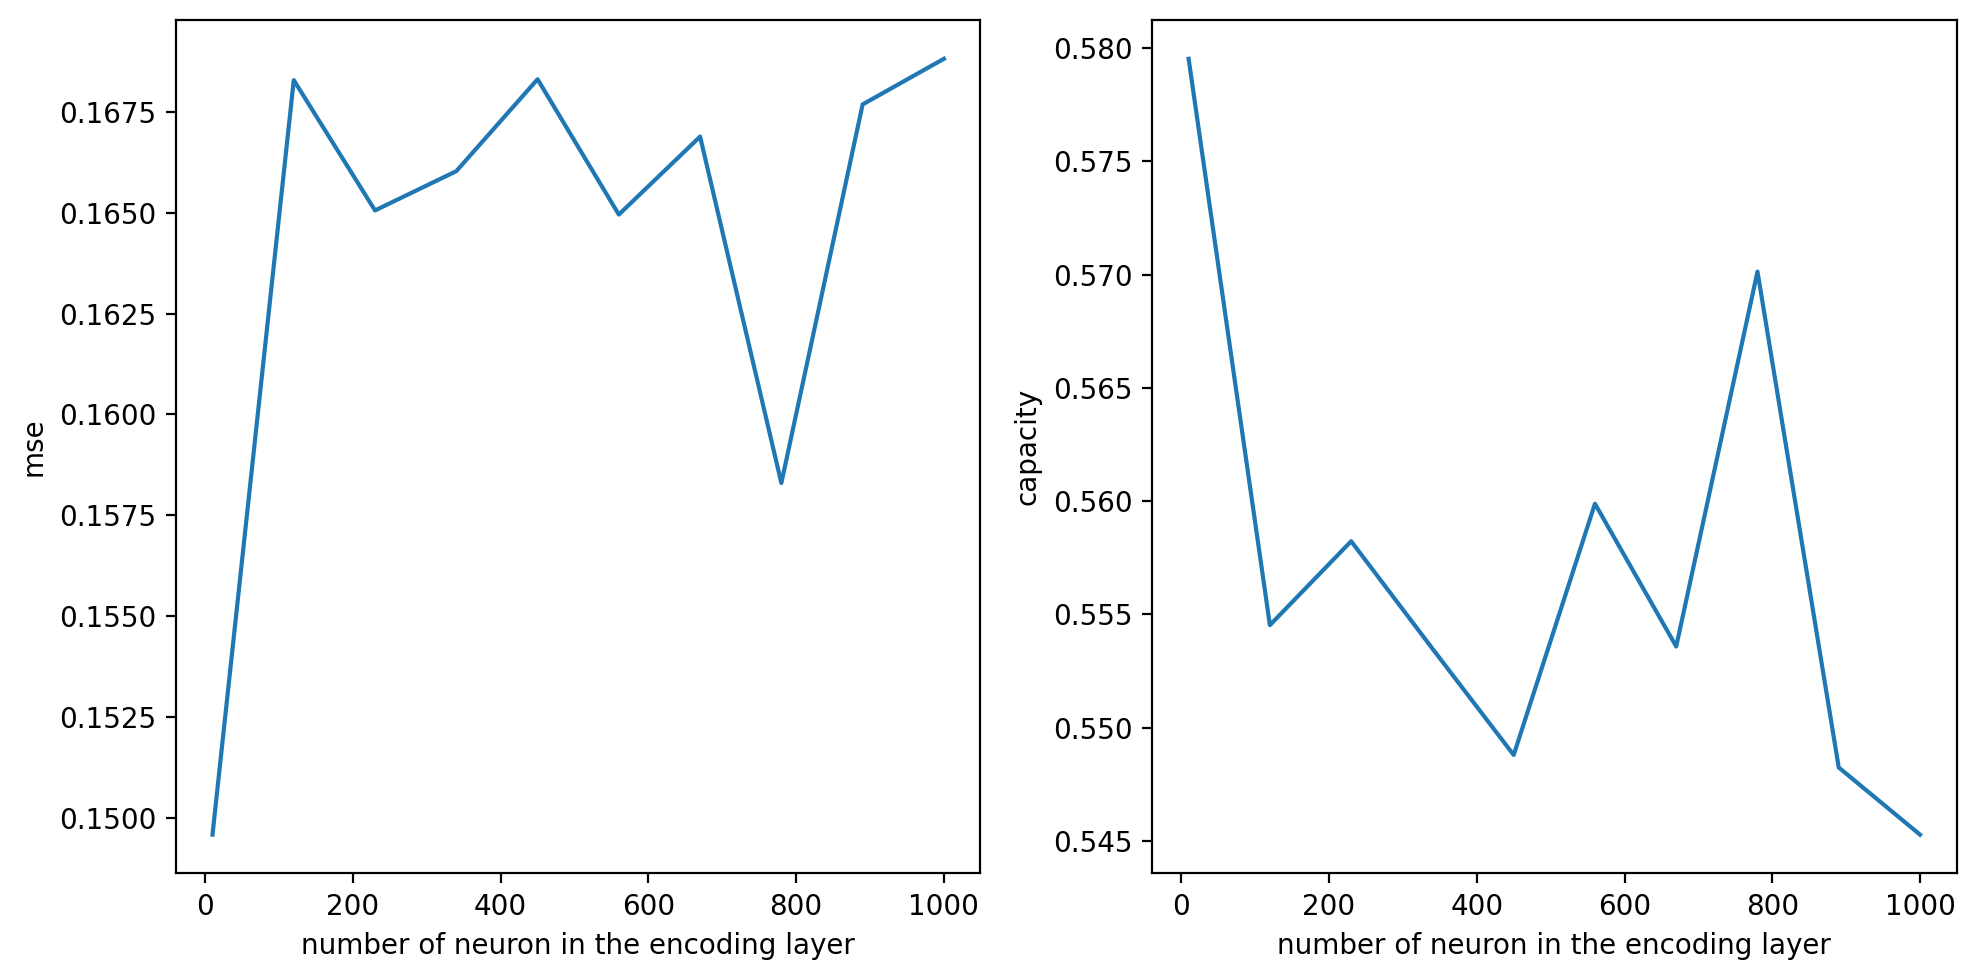

In [46]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10,5),
    dpi=200
)

ax[0].plot(
    nEnc_range,
    MSE_nEnc
)
ax[0].set_ylabel("mse")
ax[0].set_xlabel("number of neuron in the encoding layer")

ax[1].plot(
    nEnc_range,
    C_nEnc
)
ax[1].set_ylabel("capacity")
ax[1].set_xlabel("number of neuron in the encoding layer")

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "encoding_neuron_number__influence.pdf"), dpi=200)
plt.show()


### change the input

In [47]:
step_duration = 20.
num_steps = 100
nEnc = 500

In [225]:
sim_time = num_steps * step_duration

# initialize nest kernel
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': num_threads
})

# generate the network
enc_layer, enc_spks, main_spks = gen_network(
    gamma=gamma,
    nEnc=nEnc,
    J_bias=J_bias,
    NE=NE, CE=CE,
    w=w, g=g, d=d
)

# generation input and connect it to the network
sig, times, inp_times, inp_amplitudes = gen_input(
    nEnc=nEnc,
    scale=scale,
    step_duration=step_duration,
    num_steps=num_steps,
)

plt.plot(sig)

# # run the simulation
# nest.Simulate(sim_time)

# # results extraction
# enc_activity, enc_states, main_activity, main_states = extract_results(
#     enc_spks=enc_spks,
#     main_spks=main_spks,
#     filter_tau=filter_tau,
#     nEnc=nEnc, NE=NE,
#     sim_time=sim_time
# )

# print(sig[:-1].shape, enc_states.shape)
# enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[:-1])
# main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[:-1])


Oct 18 15:59:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
